<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/Squarepacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#This only installs the MILP solver cbc and pyomo, no other solvers,

try:
  not_first_time == True
except:
  import os
  !pip install -q pyomo
  !apt-get install -y -qq coinor-cbc
  not_first_time = True
finally:
  print("Pyomo and cbc solver installed")

Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to unpack .../4-coinor-libcbc3_2.10.7+ds1-1_amd64.deb ...
Unpacking coinor-libcbc3:

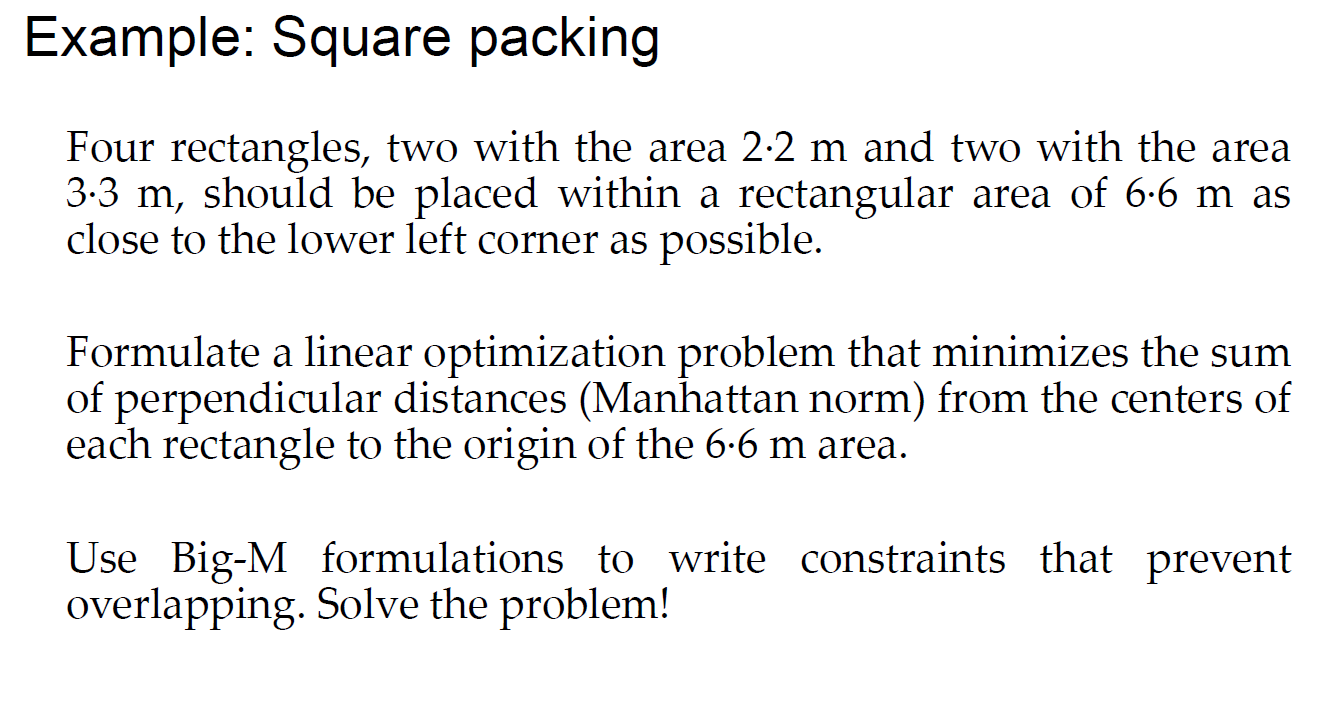

Packing squares as close to lower left corner

$\begin{align}
\min \sum_{i \in S} x_i + y_i \end{align}$

s.t.


$Y_{1,ii^\prime}+Y_{2,ii^\prime}+Y_{3,ii^\prime}+Y_{4,ii^\prime} = 1$

$x_i - x_{i^\prime} \le 0.5(w_i+w_{i^\prime})-M(1-Y_{1,ii^\prime}) \ \forall i,i^\prime \in S$

$x_{i^\prime}-x_i \le 0.5(w_i+w_{i^\prime})-M(1-Y_{2,ii^\prime}) \ \forall i,i^\prime \in S$

$y_i - y_{i^\prime} \le 0.5(h_i+h_{i^\prime})-M(1-Y_{3,ii^\prime}) \ \forall i,i^\prime \in S$

$y_{i^\prime} -y_i \le 0.5(h_i+h_{i^\prime})-M(1-Y_{4,ii^\prime}) \ \forall i,i^\prime \in S$

$0.5w_i \le x_i \le W - 0.5 w_i \forall i \in S$

$0.5h_i \le y_i \le H - 0.5 h_i \forall i \in S$

$x_i \in \mathbb{Z}_{\ge 0} \;\; \forall i \in S$

$Y_{1,ii^\prime},Y_{2,ii^\prime},Y_{3,ii^\prime},Y_{4,ii^\prime} \in \{0,1 \} \ \forall i,i^\prime \in S$

$S=\{R_1,R_2,R_3,R_4\}$

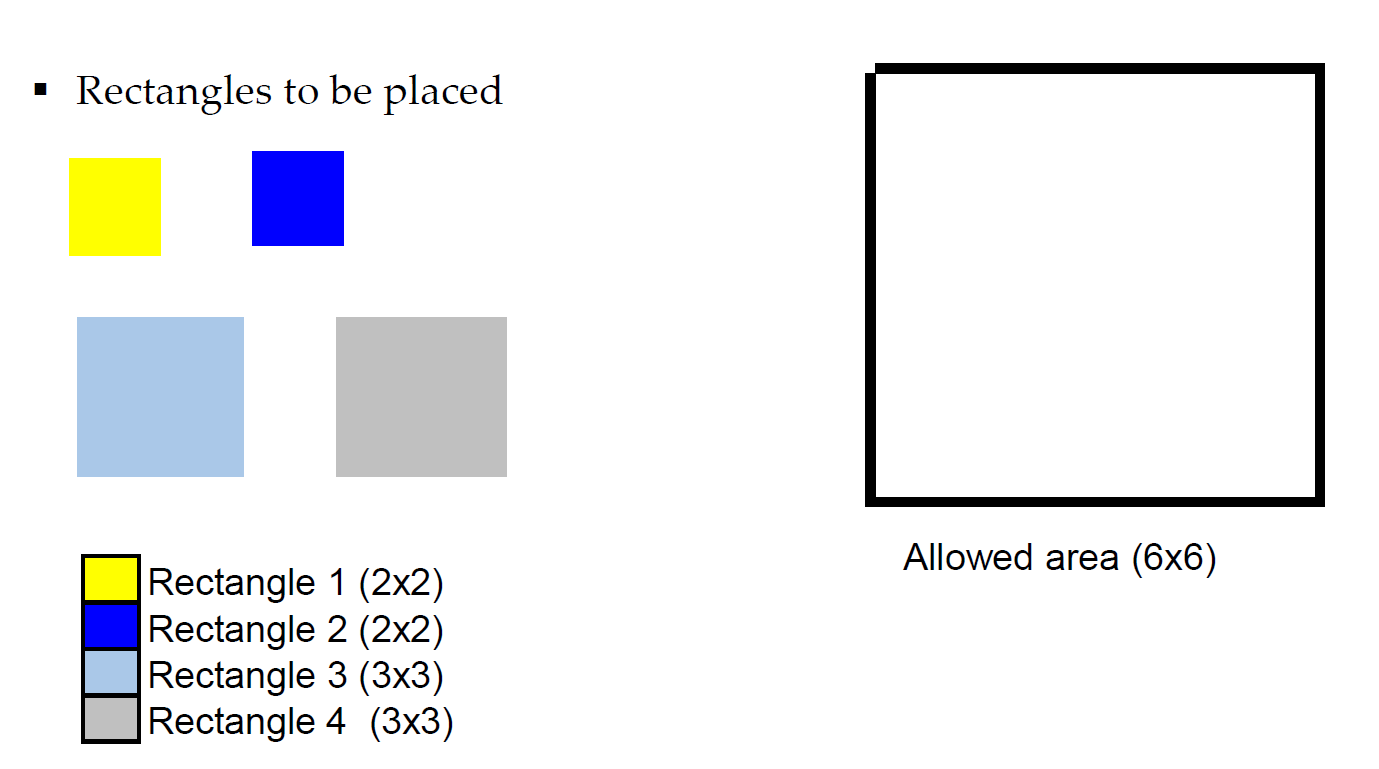

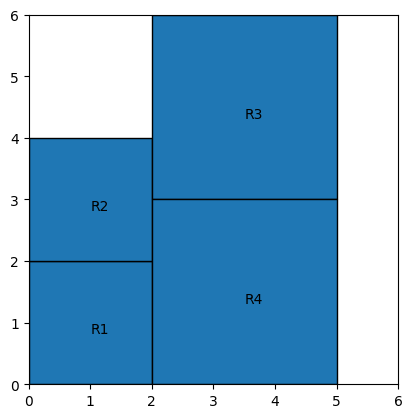

Solution  x[R1] + y[R1] + x[R2] + y[R2] + x[R3] + y[R3] + x[R4] + y[R4] = 19.0


In [2]:
from pyomo.environ import *
import matplotlib.pyplot as plt


#We crate the model object, here called "mod"
mod=ConcreteModel()


mod.squares = Set(initialize=['R1','R2','R3','R4'],doc='Squares')
mod.w = Param(mod.squares,initialize={'R1':2,'R2':2,'R3':3,'R4':3},doc='Width of square')
mod.h = Param(mod.squares,initialize={'R1':2,'R2':2,'R3':3,'R4':3},doc='Height of square')

#Max and min positions for the center point of the squares
mod.W = Param(initialize=6,doc='Width')
mod.H = Param(initialize=6,doc='Heigth')

mod.x = Var(mod.squares,within=NonNegativeReals,doc='x-position of the center')
mod.y = Var(mod.squares,within=NonNegativeReals,doc='y-position of the center')
mod.Y1 = Var(mod.squares,mod.squares,within=Binary,doc='indicator variable 1')
mod.Y2 = Var(mod.squares,mod.squares,within=Binary,doc='indicator variable 2')
mod.Y3 = Var(mod.squares,mod.squares,within=Binary,doc='indicator variable 3')
mod.Y4 = Var(mod.squares,mod.squares,within=Binary,doc='indicator variable 4')


#BigM, "cheap" way of specifying a parameter, not a Pyomo parameter
mod.BigM = 10

def Overlap0_rule(mod,i,j):
    if i != j:
        return mod.Y1[i,j]+mod.Y2[i,j] +mod.Y3[i,j]+mod.Y4[i,j] >= 1
    else:
        return Constraint.Skip
mod.Overlap0 = Constraint(mod.squares,mod.squares,rule=Overlap0_rule,doc='One of the disjuncts')

#Overlap preventing rules
def Overlap1_rule(mod,i,j):
    if i != j:
        return mod.x[i]-mod.x[j]  >= 0.5*(mod.w[i]+mod.w[j]) - mod.BigM*(1-mod.Y1[i,j])
    else:
        return Constraint.Skip
mod.Overlap1=Constraint(mod.squares,mod.squares,rule=Overlap1_rule,doc='Disjunct 1')

def Overlap2_rule(mod,i,j):
    if i != j:
        return mod.x[j]-mod.x[i]  >= 0.5*(mod.w[i]+mod.w[j]) - mod.BigM*(1-mod.Y2[i,j])
    else:
        return Constraint.Skip
mod.Overlap2=Constraint(mod.squares,mod.squares,rule=Overlap2_rule,doc='Disjunct 2')

def Overlap3_rule(mod,i,j):
    if i != j:
        return mod.y[i]-mod.y[j] >= 0.5*(mod.h[i]+mod.h[j]) - mod.BigM*(1-mod.Y3[i,j])
    else:
        return Constraint.Skip
mod.Overlap3=Constraint(mod.squares,mod.squares,rule=Overlap3_rule,doc='Disjunct 3')

def Overlap4_rule(mod,i,j):
    if i != j:
        return mod.y[j]-mod.y[i] >= 0.5*(mod.h[i]+mod.h[j]) - mod.BigM*(1-mod.Y4[i,j])
    else:
        return Constraint.Skip
mod.Overlap4=Constraint(mod.squares,mod.squares,rule=Overlap4_rule,doc='Disjunct 4')

#Inside box rules
def Wposmin_rule(mod,i):
    return mod.x[i] >= 0.5*mod.w[i]
mod.Wposmin=Constraint(mod.squares,rule=Wposmin_rule,doc='right of xmin')

def Wposmax_rule(mod,i):
    return mod.x[i] <= mod.W-0.5*mod.w[i]
mod.Wposmax=Constraint(mod.squares,rule=Wposmax_rule,doc='left of xmax')

def Hposmin_rule(mod,i):
    return mod.y[i] >= 0.5*mod.h[i]
mod.Hposmin=Constraint(mod.squares,rule=Hposmin_rule,doc='above ymin')

def Hposmax_rule(mod,i):
    return mod.y[i] <=mod.H-0.5*mod.h[i]
mod.Hposmax=Constraint(mod.squares,rule=Hposmax_rule, doc='below ymax')

#additional symmetry breaking (for same result as in slides)
mod.sym1=Constraint(expr=mod.x['R1']<= mod.x['R2'])
mod.sym2=Constraint(expr=mod.y['R1']<= mod.y['R2'])

#Object function, sum of Manhattan norms
mod.obj=Objective(expr=sum(mod.x[i]+mod.y[i] for i in mod.squares),sense=minimize)

#mod.pprint()

#Specify solver
solver = SolverFactory('cbc',executable='/bin/cbc')

#Verbous solving
results = solver.solve(mod,tee=False)

#mod.display()

#plot the result (only one "subplot" specified)
figure, axes = plt.subplots()

for i in mod.squares:
    left=mod.x[i].value-0.5*mod.w[i]
    bottom=mod.y[i].value-0.5*mod.h[i]
    p = plt.Rectangle((left,bottom), mod.w[i],mod.h[i], fill=True,edgecolor='black')
    axes.add_artist(p)
    axes.text(left+mod.w[i]/2, bottom+mod.h[i]/2, i,
         horizontalalignment='left', verticalalignment='top')

axes.set_aspect(1)

plt.xlim(0,6)
plt.ylim(0,6)
plt.show()
print('Solution ',mod.obj.expr,'=', mod.obj())